In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [211]:
df = pd.read_csv('HeartDisease.csv')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

In [212]:
nan_counts = df.isna().sum()
print(nan_counts)

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
HeartDisease         0
dtype: int64


In [213]:
mean_value = df.mean(skipna=True).round(1)
median_value = df.median(skipna=True)
mode_value = df.mode(dropna=True).iloc[0]

print(mean_value)
print(median_value)
print(mode_value)

male                 0.4
age                 49.6
education            2.0
currentSmoker        0.5
cigsPerDay           9.0
BPMeds               0.0
prevalentStroke      0.0
prevalentHyp         0.3
diabetes             0.0
totChol            236.7
sysBP              132.4
diaBP               82.9
BMI                 25.8
heartRate           75.9
glucose             82.0
HeartDisease         0.2
dtype: float64
male                 0.0
age                 49.0
education            2.0
currentSmoker        0.0
cigsPerDay           0.0
BPMeds               0.0
prevalentStroke      0.0
prevalentHyp         0.0
diabetes             0.0
totChol            234.0
sysBP              128.0
diaBP               82.0
BMI                 25.4
heartRate           75.0
glucose             78.0
HeartDisease         0.0
dtype: float64
male                 0.00
age                 40.00
education            1.00
currentSmoker        0.00
cigsPerDay           0.00
BPMeds               0.00
prevalentStrok

In [214]:
print(df.columns.tolist())
binary_fields = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]
continuous_fields = [col for col in df.columns if col not in binary_fields]
print(binary_fields)
print(continuous_fields)

['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'HeartDisease']
['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'HeartDisease']
['age', 'education', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


In [215]:
for field in df.columns.tolist():
    if(field in binary_fields):
        df[field] = df[field].fillna(mode_value[field])
    else:
        df[field] = df[field].fillna(mean_value[field])

nan_counts = df.isna().sum()
print(nan_counts)

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
HeartDisease       0
dtype: int64


In [216]:
data_size = len(df)
train_size = int(0.70 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size+test_size]
val_data = df.iloc[train_size+test_size:]

print(f"Train set: {len(train_data)} samples")
print(f"Test set: {len(test_data)} samples")
print(f"Validation set: {len(val_data)} samples")

train_data.to_csv('train_heart.csv', index=False)
test_data.to_csv('test_heart.csv', index=False)
val_data.to_csv('val_heart.csv', index=False)

Train set: 2966 samples
Test set: 635 samples
Validation set: 637 samples


In [217]:
print(train_size, val_size, test_size)

2966 637 635


In [218]:
def fit_transform(X):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_scaled = (X - X_min) / (X_max - X_min)
    return X_scaled, X_min, X_max

def transform(X, X_min, X_max):
    X_scaled = (X - X_min) / (X_max - X_min)
    return X_scaled


In [219]:
X_train_unscaled = train_data.drop(columns=["HeartDisease"]).to_numpy()
X_train, X_min, X_max = fit_transform(X_train_unscaled)
Y_train = train_data[["HeartDisease"]].to_numpy()
Y_train = np.ravel(Y_train)

X_val_unscaled = val_data.drop(columns=["HeartDisease"]).to_numpy()
X_val = transform(X_val_unscaled, X_min, X_max)
Y_val = val_data[["HeartDisease"]].to_numpy()
Y_val = np.ravel(Y_val)

X_test_unscaled = test_data.drop(columns=["HeartDisease"]).to_numpy()
X_test = transform(X_test_unscaled, X_min, X_max)
Y_test = test_data[["HeartDisease"]].to_numpy()
Y_test = np.ravel(Y_test)

print("NaNs in train set:", np.isnan(X_train).sum())
print("NaNs in val set:", np.isnan(X_val).sum())
print("NaNs in test set:", np.isnan(X_test).sum())

NaNs in train set: 0
NaNs in val set: 0
NaNs in test set: 0


In [220]:
def add_bias(X):
    bias = np.ones((X.shape[0], 1))
    return np.hstack((bias, X))
X_train_unscaled = add_bias(X_train_unscaled)
X_val_unscaled = add_bias(X_val_unscaled)
X_test_unscaled = add_bias(X_test_unscaled)
X_train = add_bias(X_train)
X_val = add_bias(X_val)
X_test = add_bias(X_test)

In [221]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1/(1 + np.exp(-z))

In [222]:
def model(X, W):
    H = sigmoid(np.dot(X,W))
    H = np.clip(H, 1e-15, 1-1e-15)
    return H

In [223]:
def cost(H, Y, W, reg, lambda_):
    m = len(Y)
    J = - (np.dot(Y,np.log(H)) + np.dot((1-Y), np.log(1-H))) / m
    reg_term = 0

    if(reg == 'L1'):
        reg_term = (lambda_) * (np.sum(np.square(W))) / (2*m)
    elif(reg == 'L2'):
        reg_term = (lambda_) * (np.sum(np.abs(W))) / (m)
    
    return J + reg_term

In [224]:
def predict(H):
    return (H >= 0.5).astype(int)

In [225]:
def calculate_accuracy(predictions, Y):
    correct_predictions = np.sum(predictions == Y)
    accuracy = correct_predictions / len(Y)
    return accuracy * 100

In [226]:
def gradient_descent(X_train, Y_train, X_val, Y_val, X_test, Y_test, lr, epochs, batch_size, patience= np.inf, reg= 'None', lambda_= 0):

    cost_train_list = []
    cost_val_list = []
    cost_test_list = []
    accuracy_train_list = []
    accuracy_val_list = []
    accuracy_test_list = []

    m = len(Y_train)
    W = np.zeros(X_train.shape[1])
    patience_counter = 0
    best_val_loss = np.inf
    epoch = 0
    for i in range(epochs + 1):
        for j in range(0, m, batch_size):
            X_batch = X_train[j:j+batch_size]
            Y_batch = Y_train[j:j+batch_size]

            H_batch = model(X_batch, W)

            residual = (H_batch - Y_batch)
            
            gradient_W = np.dot(X_batch.T, residual) / batch_size
            
            W -= lr * gradient_W
        
        H_train = model(X_train, W)
        J_train = cost(H_train, Y_train, W, reg, lambda_)
        H_val = model(X_val, W)
        J_val = cost(H_val, Y_val, W, reg, lambda_)
        H_test = model(X_test, W)
        J_test = cost(H_test, Y_test, W, reg, lambda_)
        
        cost_train_list.append(J_train)
        cost_val_list.append(J_val)
        cost_test_list.append(J_test)
        
        train_predictions = predict(H_train)
        val_predictions = predict(H_val)
        test_predictions = predict(H_test)
        train_accuracy = calculate_accuracy(train_predictions, Y_train)
        val_accuracy = calculate_accuracy(val_predictions, Y_val)
        test_accuracy = calculate_accuracy(test_predictions, Y_test)
        
        accuracy_train_list.append(train_accuracy)
        accuracy_val_list.append(val_accuracy)
        accuracy_test_list.append(test_accuracy)
        
        epoch = i
        if (i % 10 == 0) or (i == epochs):
            print(f"Epoch {epoch}: Train Loss: {J_train:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        if round(J_val, 5) < round(best_val_loss, 5):
            best_val_loss = J_val
            best_weights = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i}, best validation loss: {best_val_loss:.4f}")
            W = best_weights
            break
    
    return W, cost_train_list, cost_val_list, cost_test_list, accuracy_train_list, accuracy_val_list, accuracy_test_list, H_train, H_val, epoch

In [227]:
def getPlot(y_values_list, labels, title="Plot", xlabel="X-axis", ylabel="Y-axis"):
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
    if len(y_values_list) != len(labels):
        raise ValueError("Length of data_list and labels must be the same.")
    
    plt.figure(figsize=(12, 6))

    for i, data in enumerate(y_values_list):
        x_values = range(len(data))
        plt.plot(x_values, data, label=labels[i], color=colors[i % len(colors)])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [228]:
weights, cost_train_list, cost_val_list, cost_test_list, accuracy_train_list, accuracy_val_list, accuracy_test_list, H_train, H_val, _ = gradient_descent(X_train, Y_train, X_val, Y_val, X_test, Y_test, lr= 0.01, epochs=100000, batch_size = train_size)


Epoch 0: Train Loss: 0.6906, Train Accuracy: 84.96%
Epoch 10: Train Loss: 0.6669, Train Accuracy: 84.96%
Epoch 20: Train Loss: 0.6457, Train Accuracy: 84.96%
Epoch 30: Train Loss: 0.6268, Train Accuracy: 84.96%
Epoch 40: Train Loss: 0.6100, Train Accuracy: 84.96%
Epoch 50: Train Loss: 0.5949, Train Accuracy: 84.96%
Epoch 60: Train Loss: 0.5814, Train Accuracy: 84.96%
Epoch 70: Train Loss: 0.5694, Train Accuracy: 84.96%
Epoch 80: Train Loss: 0.5585, Train Accuracy: 84.96%
Epoch 90: Train Loss: 0.5488, Train Accuracy: 84.96%
Epoch 100: Train Loss: 0.5400, Train Accuracy: 84.96%
Epoch 110: Train Loss: 0.5321, Train Accuracy: 84.96%
Epoch 120: Train Loss: 0.5250, Train Accuracy: 84.96%
Epoch 130: Train Loss: 0.5185, Train Accuracy: 84.96%
Epoch 140: Train Loss: 0.5126, Train Accuracy: 84.96%
Epoch 150: Train Loss: 0.5073, Train Accuracy: 84.96%
Epoch 160: Train Loss: 0.5025, Train Accuracy: 84.96%
Epoch 170: Train Loss: 0.4981, Train Accuracy: 84.96%
Epoch 180: Train Loss: 0.4940, Train Ac

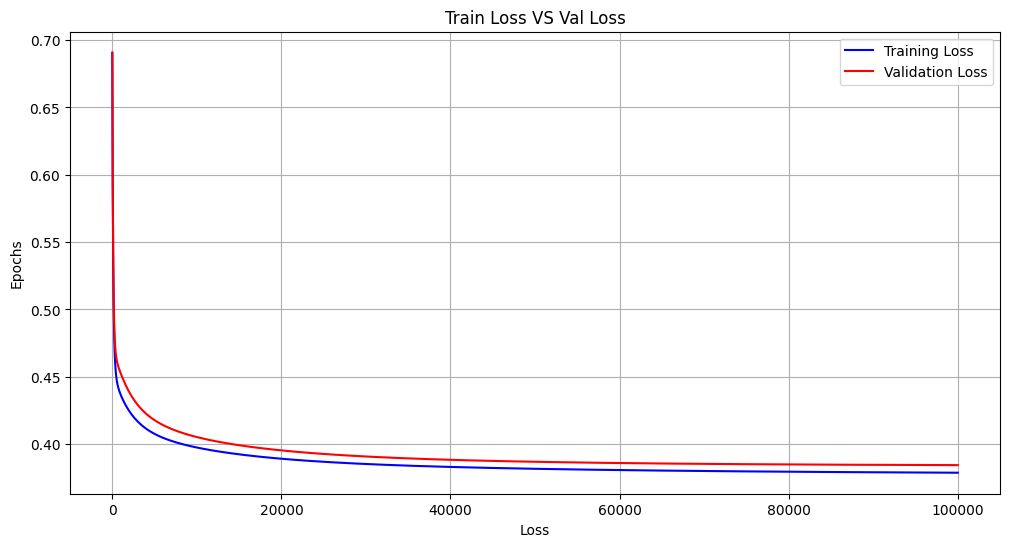

In [229]:
y_values_list = [cost_train_list, cost_val_list]
labels = ['Training Loss', 'Validation Loss']
getPlot(y_values_list ,labels, 'Train Loss VS Val Loss', 'Loss', 'Epochs')

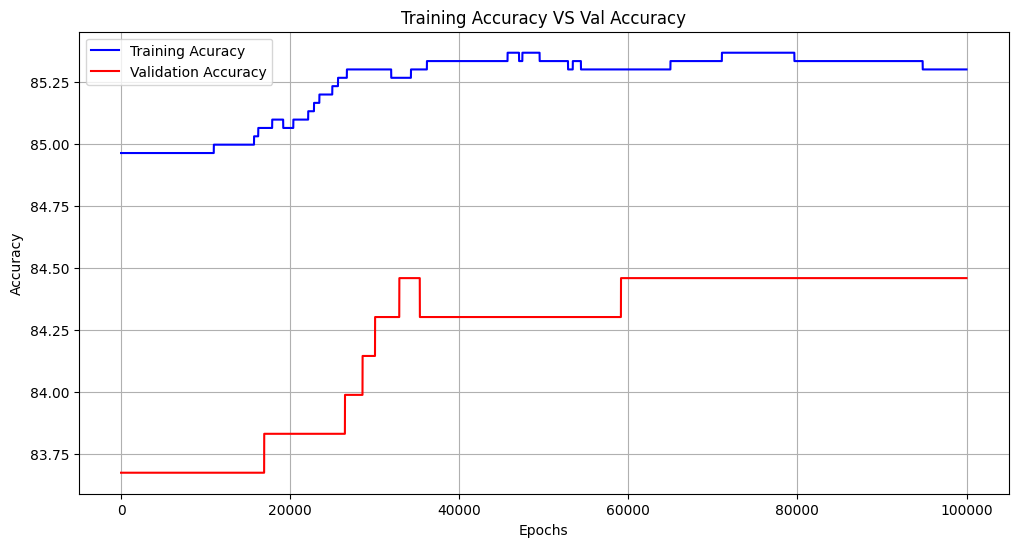

In [230]:
y_values_list = [accuracy_train_list, accuracy_val_list] 
labels = ['Training Acuracy', 'Validation Accuracy']
getPlot(y_values_list, labels, 'Training Accuracy VS Val Accuracy', 'Epochs', 'Accuracy')

In [231]:
weights_unscaled, cost_train_list_unscaled, cost_val_list_unscaled, _, accuracy_train_list_unscaled, accuracy_val_list_unscaled, _, _, _, _ = gradient_descent(X_train_unscaled, Y_train, X_val_unscaled, Y_val, X_test_unscaled, Y_test, lr= 0.01, epochs= 100000, batch_size = train_size)

Epoch 0: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 10: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 20: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 30: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 40: Train Loss: 1.8221, Train Accuracy: 82.81%
Epoch 50: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 60: Train Loss: 1.9442, Train Accuracy: 70.80%
Epoch 70: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 80: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 90: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 100: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 110: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 120: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 130: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 140: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 150: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 160: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 170: Train Loss: 5.1936, Train Accuracy: 84.96%
Epoch 180: Train Loss: 5.1936, Train Ac

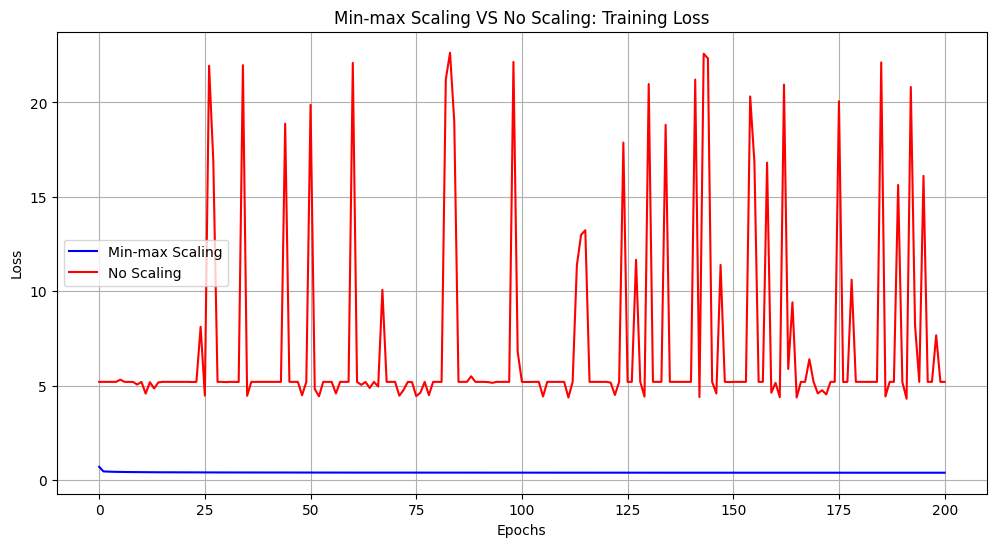

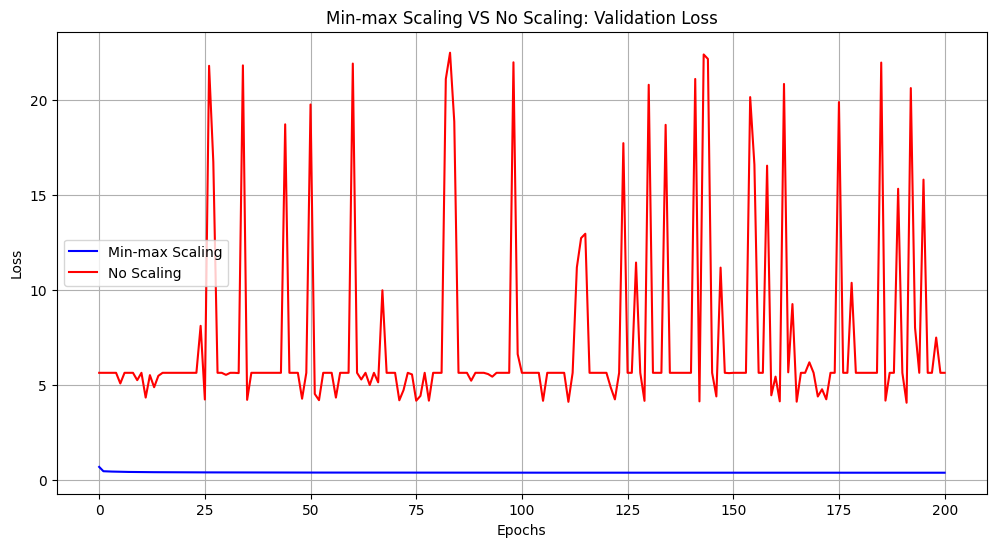

In [232]:
y_values_list = [cost_train_list[::500], cost_train_list_unscaled[::500]]
labels = ['Min-max Scaling', 'No Scaling']
getPlot(y_values_list, labels, 'Min-max Scaling VS No Scaling: Training Loss', 'Epochs', 'Loss')
y_values_list = [cost_val_list[::500], cost_val_list_unscaled[::500]]
getPlot(y_values_list, labels, 'Min-max Scaling VS No Scaling: Validation Loss', 'Epochs', 'Loss')

In [233]:
Y_pred = predict(H_val)

precision = precision_score(Y_val, Y_pred)
recall = recall_score(Y_val, Y_pred)
f1 = f1_score(Y_val, Y_pred)
roc_auc = roc_auc_score(Y_val, Y_pred)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"ROC-AUC Score: {roc_auc*100:.2f}%")

Precision: 85.71%
Recall: 5.77%
F1 Score: 10.81%
ROC-AUC Score: 52.79%


In [234]:
batch_size_list = [1, 64, 256, 1024, train_size]
train_loss_lists = []
test_loss_lists = []
val_loss_lists = []
train_accuracy_lists = []
val_accuracy_lists = []
test_accuracy_lists = []

for batch_size in batch_size_list:
    print(f"BATCH SIZE: {batch_size} -----------------------------------------")
    weights_mb, cost_train_list_mb, cost_val_list_mb, cost_test_list_mb, accuracy_train_list_mb, accuracy_val_list_mb, accuracy_test_list_mb, _, _, _ = gradient_descent(X_train, Y_train, X_val, Y_val, X_test, Y_test, lr= 0.001, epochs=1000, batch_size= batch_size)
    train_loss_lists.append(cost_train_list_mb)
    val_loss_lists.append(cost_val_list_mb)
    test_loss_lists.append(cost_test_list_mb)
    train_accuracy_lists.append(accuracy_train_list_mb)
    val_accuracy_lists.append(accuracy_val_list_mb)
    test_accuracy_lists.append(accuracy_test_list_mb)

BATCH SIZE: 1 -----------------------------------------
Epoch 0: Train Loss: 0.4662, Train Accuracy: 84.96%
Epoch 10: Train Loss: 0.4152, Train Accuracy: 84.96%
Epoch 20: Train Loss: 0.4041, Train Accuracy: 84.96%
Epoch 30: Train Loss: 0.3986, Train Accuracy: 84.96%
Epoch 40: Train Loss: 0.3950, Train Accuracy: 85.00%
Epoch 50: Train Loss: 0.3923, Train Accuracy: 85.00%
Epoch 60: Train Loss: 0.3902, Train Accuracy: 85.10%
Epoch 70: Train Loss: 0.3886, Train Accuracy: 85.10%
Epoch 80: Train Loss: 0.3872, Train Accuracy: 85.20%
Epoch 90: Train Loss: 0.3861, Train Accuracy: 85.30%
Epoch 100: Train Loss: 0.3852, Train Accuracy: 85.30%
Epoch 110: Train Loss: 0.3844, Train Accuracy: 85.27%
Epoch 120: Train Loss: 0.3838, Train Accuracy: 85.33%
Epoch 130: Train Loss: 0.3832, Train Accuracy: 85.33%
Epoch 140: Train Loss: 0.3827, Train Accuracy: 85.33%
Epoch 150: Train Loss: 0.3823, Train Accuracy: 85.33%
Epoch 160: Train Loss: 0.3819, Train Accuracy: 85.37%
Epoch 170: Train Loss: 0.3816, Train 

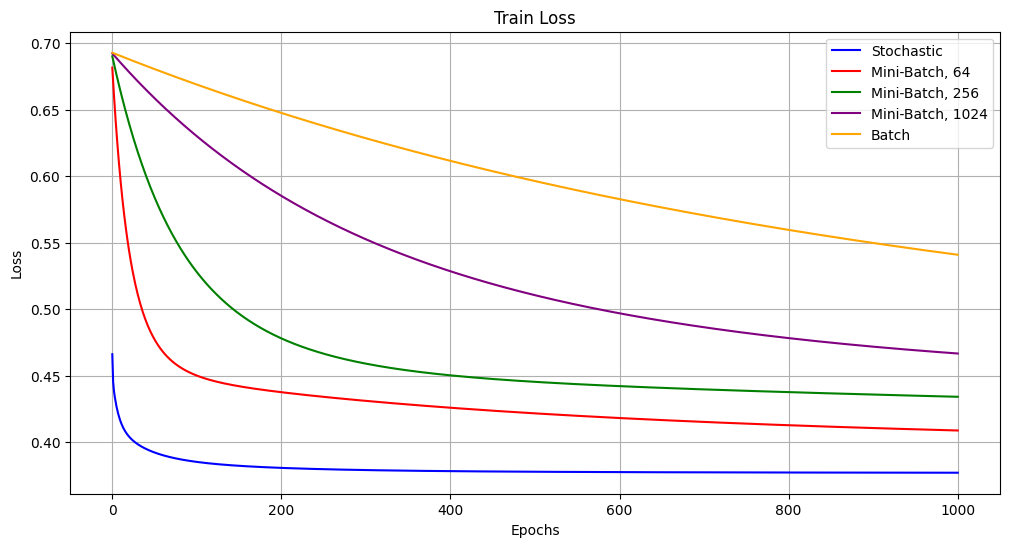

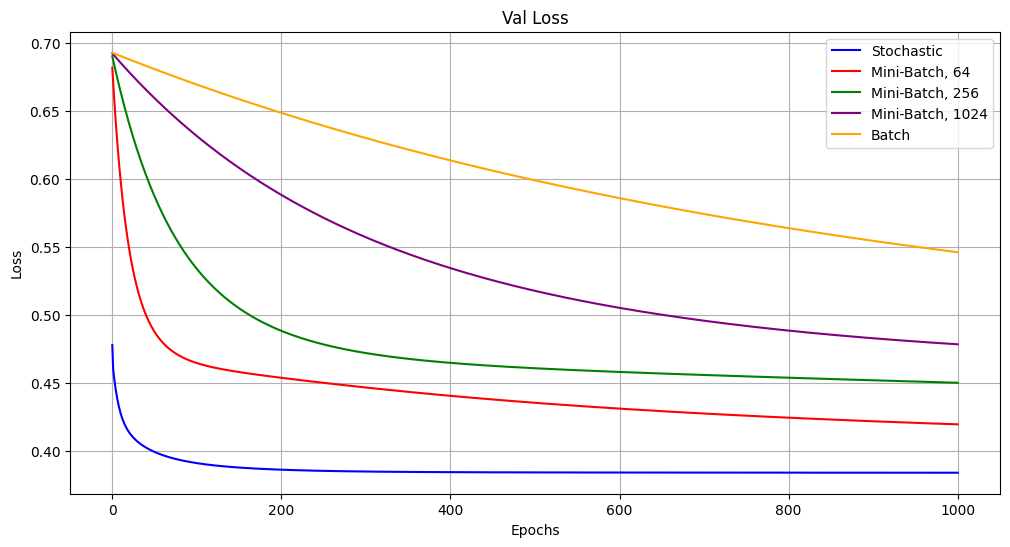

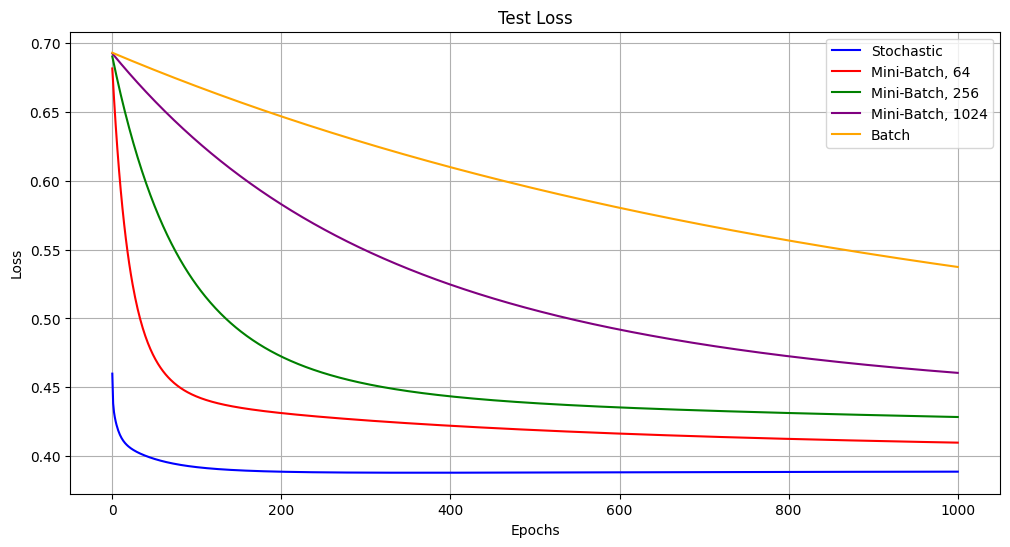

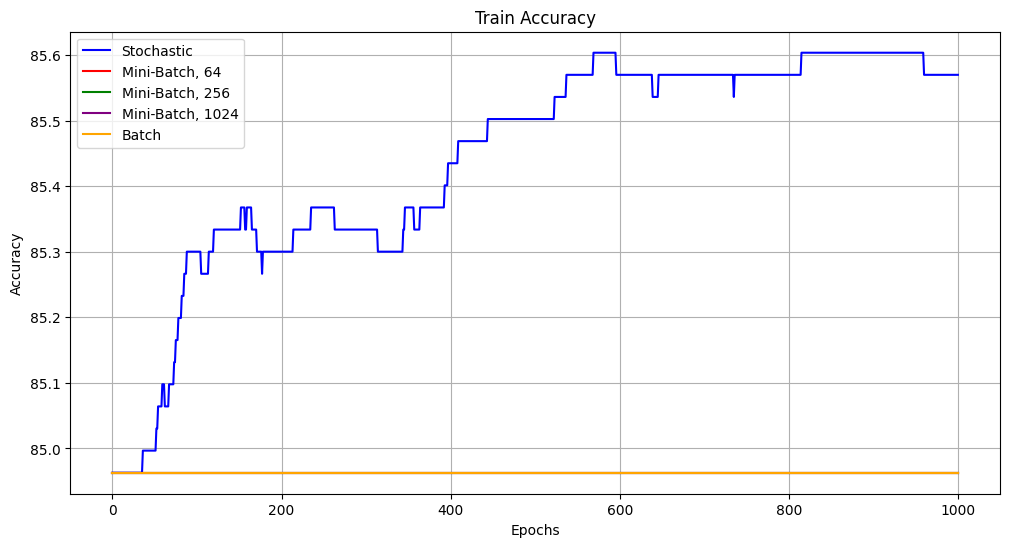

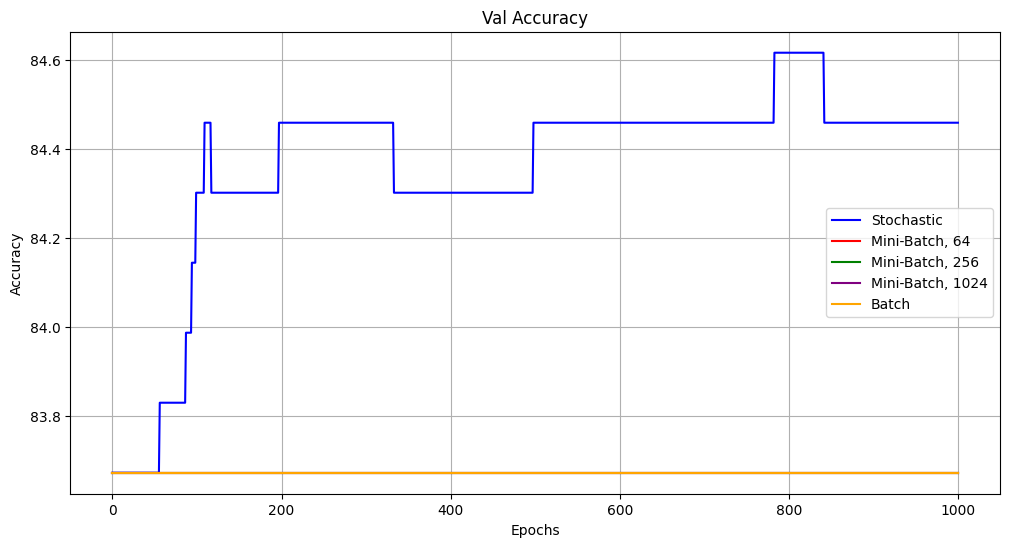

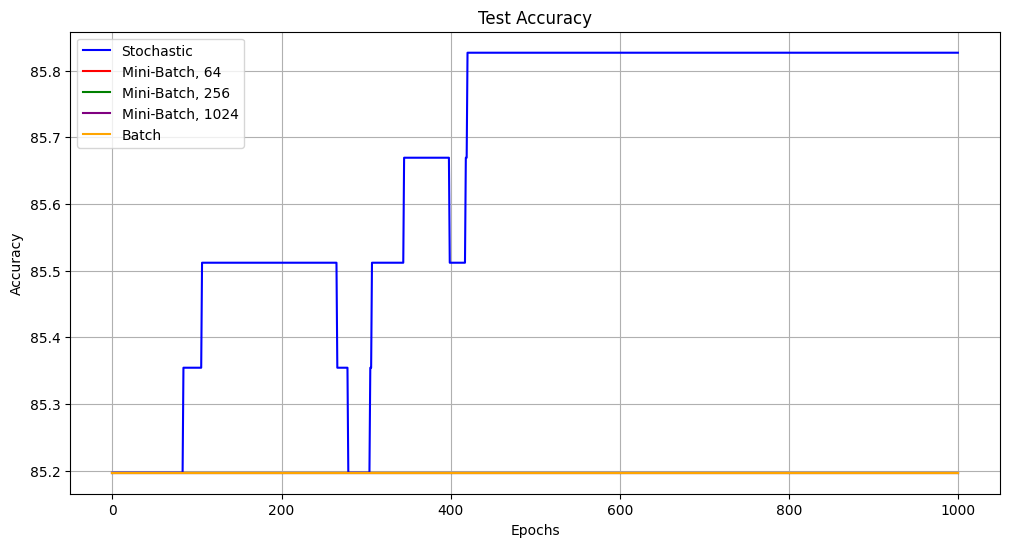

In [235]:
labels = ['Stochastic', 'Mini-Batch, 64', 'Mini-Batch, 256', 'Mini-Batch, 1024', 'Batch']
getPlot(train_loss_lists, labels, 'Train Loss', 'Epochs', 'Loss')
getPlot(val_loss_lists, labels, 'Val Loss', 'Epochs', 'Loss')
getPlot(test_loss_lists, labels, 'Test Loss', 'Epochs', 'Loss')
getPlot(train_accuracy_lists, labels, 'Train Accuracy', 'Epochs', 'Accuracy')
getPlot(val_accuracy_lists, labels, 'Val Accuracy', 'Epochs', 'Accuracy')
getPlot(test_accuracy_lists, labels, 'Test Accuracy', 'Epochs', 'Accuracy')

In [236]:
def k_fold_cross_validation(X, Y, k=5):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    num_samples = X.shape[0]
    fold_size = num_samples // k
    
    for i in range(k):
        start_val = i * fold_size
        end_val = (i + 1) * fold_size
        X_val_fold = X[start_val:end_val]
        Y_val_fold = Y[start_val:end_val]
        X_train_fold = np.concatenate((X[:start_val], X[end_val:]), axis=0)
        Y_train_fold = np.concatenate((Y[:start_val], Y[end_val:]), axis=0)       
        b = len(X_train_fold)
        W, _, _, _, _, _, _, _, _, _ = gradient_descent(X_train_fold, Y_train_fold, X_val_fold, Y_val_fold, X_test, Y_test, lr= 0.01, epochs= 10000, batch_size= b)
        H_val = model(X_val_fold, W)
        predictions = predict(H_val)
        accuracy = calculate_accuracy(Y_val_fold, predictions)
        precision = precision_score(Y_val_fold, predictions, zero_division=0)
        recall = recall_score(Y_val_fold, predictions, zero_division=0)
        f1 = f1_score(Y_val_fold, predictions, zero_division=0)
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        print(f"Fold {i+1}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}")
    
    return accuracies, precisions, recalls, f1_scores

In [237]:
accuracies, precisions, recalls, f1_scores = k_fold_cross_validation(X_train, Y_train)

Epoch 0: Train Loss: 0.6906, Train Accuracy: 84.83%
Epoch 10: Train Loss: 0.6670, Train Accuracy: 84.83%
Epoch 20: Train Loss: 0.6460, Train Accuracy: 84.83%
Epoch 30: Train Loss: 0.6273, Train Accuracy: 84.83%
Epoch 40: Train Loss: 0.6106, Train Accuracy: 84.83%
Epoch 50: Train Loss: 0.5956, Train Accuracy: 84.83%
Epoch 60: Train Loss: 0.5822, Train Accuracy: 84.83%
Epoch 70: Train Loss: 0.5703, Train Accuracy: 84.83%
Epoch 80: Train Loss: 0.5595, Train Accuracy: 84.83%
Epoch 90: Train Loss: 0.5498, Train Accuracy: 84.83%
Epoch 100: Train Loss: 0.5411, Train Accuracy: 84.83%
Epoch 110: Train Loss: 0.5333, Train Accuracy: 84.83%
Epoch 120: Train Loss: 0.5262, Train Accuracy: 84.83%
Epoch 130: Train Loss: 0.5198, Train Accuracy: 84.83%
Epoch 140: Train Loss: 0.5140, Train Accuracy: 84.83%
Epoch 150: Train Loss: 0.5087, Train Accuracy: 84.83%
Epoch 160: Train Loss: 0.5039, Train Accuracy: 84.83%
Epoch 170: Train Loss: 0.4995, Train Accuracy: 84.83%
Epoch 180: Train Loss: 0.4955, Train Ac

In [238]:
avg_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

avg_precision = np.mean(precisions)
std_precision = np.std(precisions)

avg_recall = np.mean(recalls)
std_recall = np.std(recalls)

avg_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("\nFinal Results:")
print(f"Average Accuracy: {avg_accuracy:.4f}%, Standard Deviation: {std_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}, Standard Deviation: {std_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}, Standard Deviation: {std_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}, Standard Deviation: {std_f1:.4f}")


Final Results:
Average Accuracy: 84.9916%, Standard Deviation: 0.5115
Average Precision: 0.2000, Standard Deviation: 0.4000
Average Recall: 0.0023, Standard Deviation: 0.0047
Average F1 Score: 0.0046, Standard Deviation: 0.0092


In [239]:
train_loss_lists = []
test_loss_lists = []
val_loss_lists = []
train_accuracy_lists = []
val_accuracy_lists = []
test_accuracy_lists = []

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
for lr in learning_rates:
    print(f"LEARNING RATE: {lr} -----------------------------------------")
    weights_es, cost_train_list_es, cost_val_list_es, cost_test_list_es, accuracy_train_list_es, accuracy_val_list_es, accuracy_test_list_es, _, _, epoch = gradient_descent(X_train, Y_train, X_val, Y_val, X_test, Y_test, lr, epochs=100000, batch_size=train_size, patience= 100)
    train_loss_lists.append(cost_train_list_es)
    val_loss_lists.append(cost_val_list_es)
    test_loss_lists.append(cost_test_list_es)
    train_accuracy_lists.append(accuracy_train_list_es)
    val_accuracy_lists.append(accuracy_val_list_es)
    test_accuracy_lists.append(accuracy_test_list_es)

LEARNING RATE: 0.1 -----------------------------------------
Epoch 0: Train Loss: 0.6685, Train Accuracy: 84.96%
Epoch 10: Train Loss: 0.5308, Train Accuracy: 84.96%
Epoch 20: Train Loss: 0.4828, Train Accuracy: 84.96%
Epoch 30: Train Loss: 0.4629, Train Accuracy: 84.96%
Epoch 40: Train Loss: 0.4532, Train Accuracy: 84.96%
Epoch 50: Train Loss: 0.4478, Train Accuracy: 84.96%
Epoch 60: Train Loss: 0.4443, Train Accuracy: 84.96%
Epoch 70: Train Loss: 0.4418, Train Accuracy: 84.96%
Epoch 80: Train Loss: 0.4397, Train Accuracy: 84.96%
Epoch 90: Train Loss: 0.4379, Train Accuracy: 84.96%
Epoch 100: Train Loss: 0.4363, Train Accuracy: 84.96%
Epoch 110: Train Loss: 0.4349, Train Accuracy: 84.96%
Epoch 120: Train Loss: 0.4335, Train Accuracy: 84.96%
Epoch 130: Train Loss: 0.4322, Train Accuracy: 84.96%
Epoch 140: Train Loss: 0.4309, Train Accuracy: 84.96%
Epoch 150: Train Loss: 0.4297, Train Accuracy: 84.96%
Epoch 160: Train Loss: 0.4286, Train Accuracy: 84.96%
Epoch 170: Train Loss: 0.4275, T

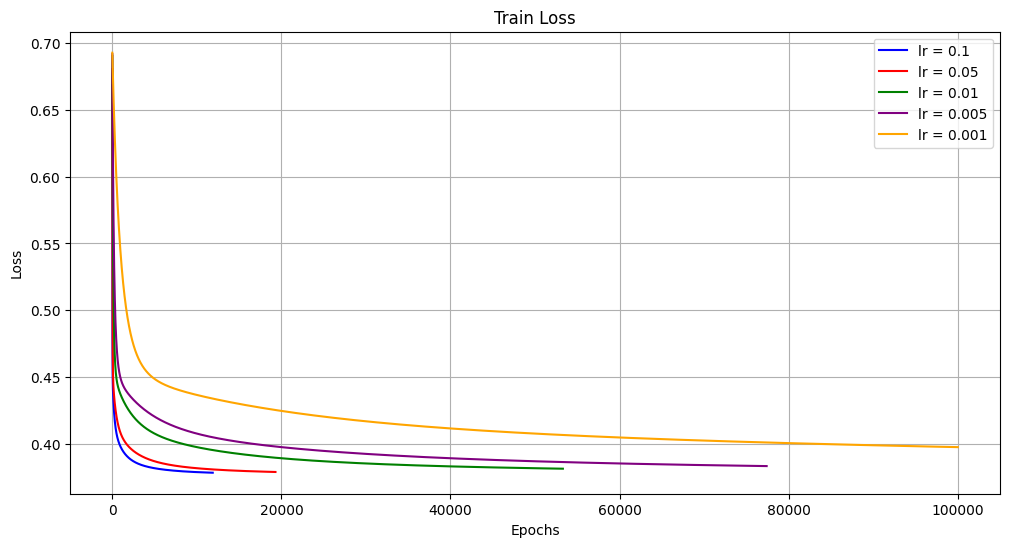

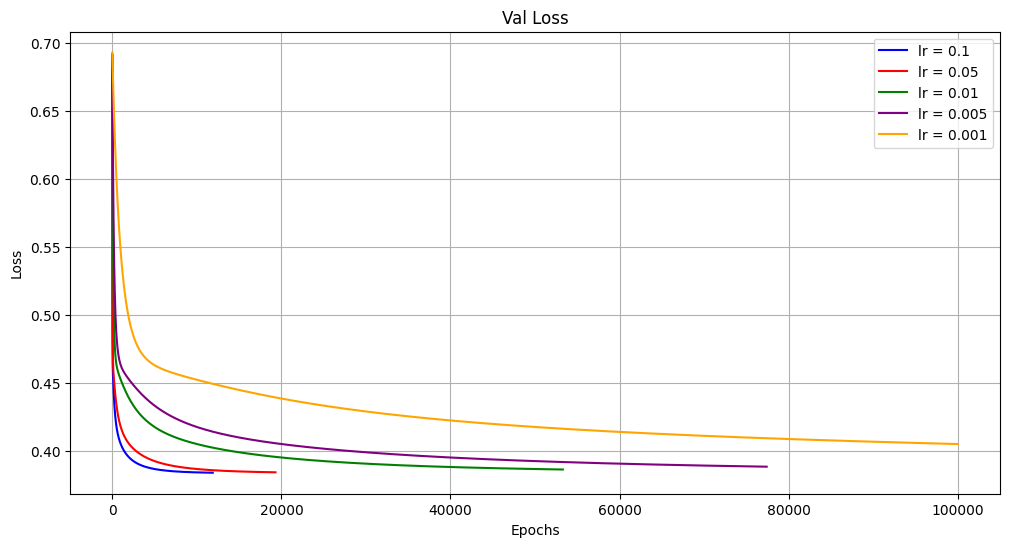

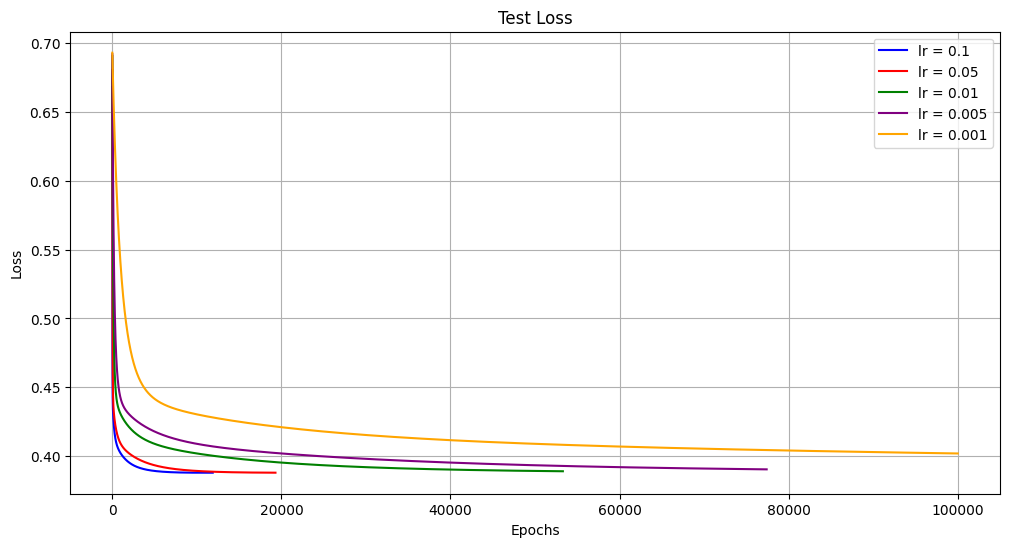

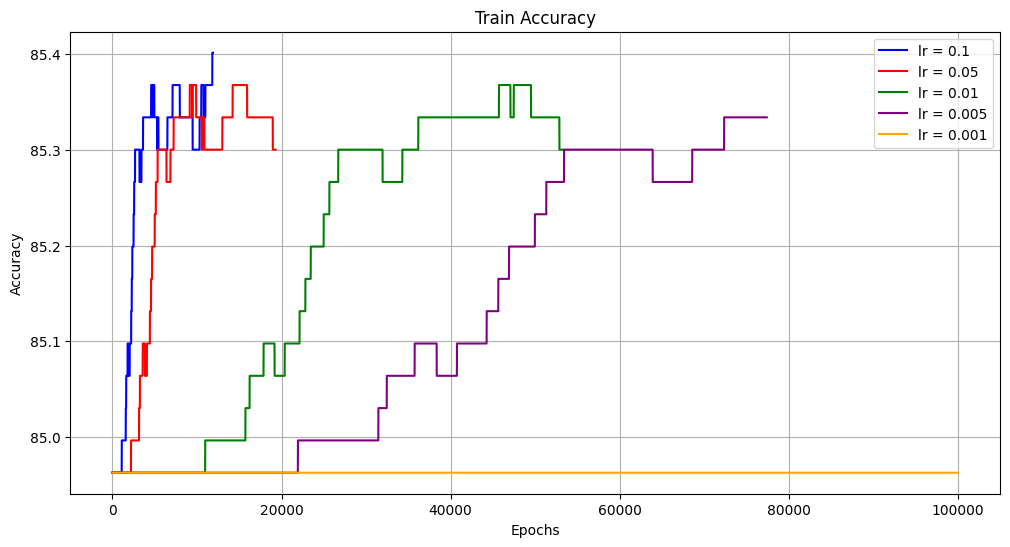

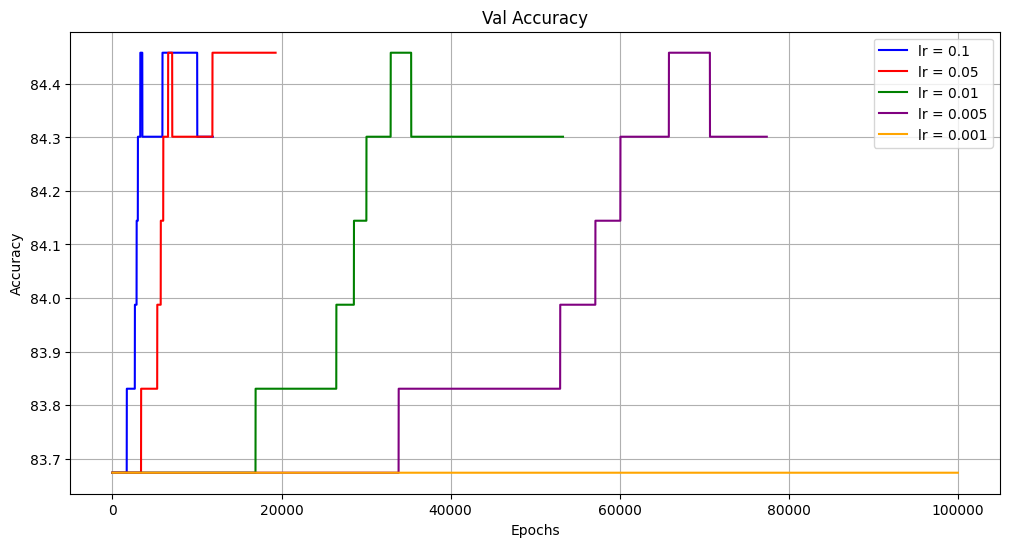

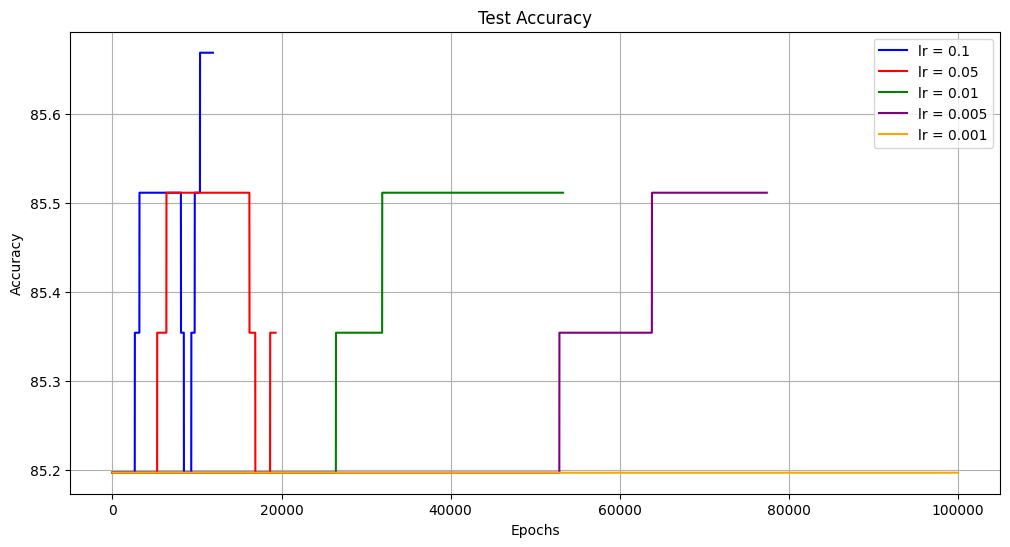

In [240]:
labels = ['lr = 0.1', 'lr = 0.05', 'lr = 0.01', 'lr = 0.005', 'lr = 0.001']
getPlot(train_loss_lists, labels, 'Train Loss', 'Epochs', 'Loss')
getPlot(val_loss_lists, labels, 'Val Loss', 'Epochs', 'Loss')
getPlot(test_loss_lists, labels, 'Test Loss', 'Epochs', 'Loss')
getPlot(train_accuracy_lists, labels, 'Train Accuracy', 'Epochs', 'Accuracy')
getPlot(val_accuracy_lists, labels, 'Val Accuracy', 'Epochs', 'Accuracy')
getPlot(test_accuracy_lists, labels, 'Test Accuracy', 'Epochs', 'Accuracy')

In [241]:
train_loss_lists = []
test_loss_lists = []
val_loss_lists = []
train_accuracy_lists = []
val_accuracy_lists = []
test_accuracy_lists = []

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
for lr in learning_rates:
    print(f"LEARNING RATE: {lr} -----------------------------------------")
    weights_es, cost_train_list_es, cost_val_list_es, cost_test_list_es, accuracy_train_list_es, accuracy_val_list_es, accuracy_test_list_es, _, _, epoch = gradient_descent(X_train, Y_train, X_val, Y_val, X_test, Y_test, lr, epochs=100000, batch_size=train_size, patience= 5000, reg= 'L1', lambda_= 2)
    train_loss_lists.append(cost_train_list_es)
    val_loss_lists.append(cost_val_list_es)
    test_loss_lists.append(cost_test_list_es)
    train_accuracy_lists.append(accuracy_train_list_es)
    val_accuracy_lists.append(accuracy_val_list_es)
    test_accuracy_lists.append(accuracy_test_list_es)

LEARNING RATE: 0.1 -----------------------------------------
Epoch 0: Train Loss: 0.6685, Train Accuracy: 84.96%
Epoch 10: Train Loss: 0.5309, Train Accuracy: 84.96%
Epoch 20: Train Loss: 0.4829, Train Accuracy: 84.96%
Epoch 30: Train Loss: 0.4631, Train Accuracy: 84.96%
Epoch 40: Train Loss: 0.4535, Train Accuracy: 84.96%
Epoch 50: Train Loss: 0.4481, Train Accuracy: 84.96%
Epoch 60: Train Loss: 0.4446, Train Accuracy: 84.96%
Epoch 70: Train Loss: 0.4421, Train Accuracy: 84.96%
Epoch 80: Train Loss: 0.4401, Train Accuracy: 84.96%
Epoch 90: Train Loss: 0.4383, Train Accuracy: 84.96%
Epoch 100: Train Loss: 0.4368, Train Accuracy: 84.96%
Epoch 110: Train Loss: 0.4353, Train Accuracy: 84.96%
Epoch 120: Train Loss: 0.4339, Train Accuracy: 84.96%
Epoch 130: Train Loss: 0.4326, Train Accuracy: 84.96%
Epoch 140: Train Loss: 0.4314, Train Accuracy: 84.96%
Epoch 150: Train Loss: 0.4302, Train Accuracy: 84.96%
Epoch 160: Train Loss: 0.4291, Train Accuracy: 84.96%
Epoch 170: Train Loss: 0.4280, T

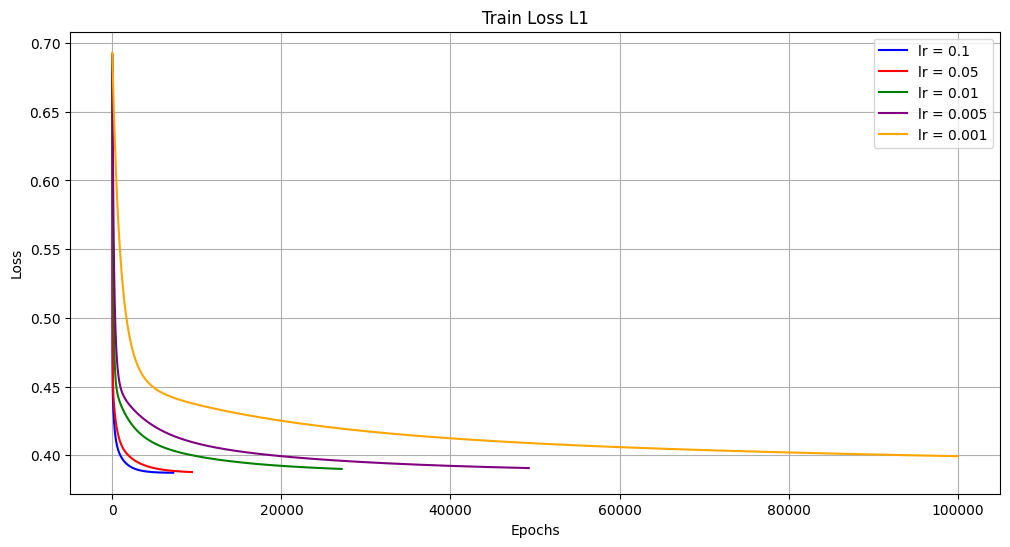

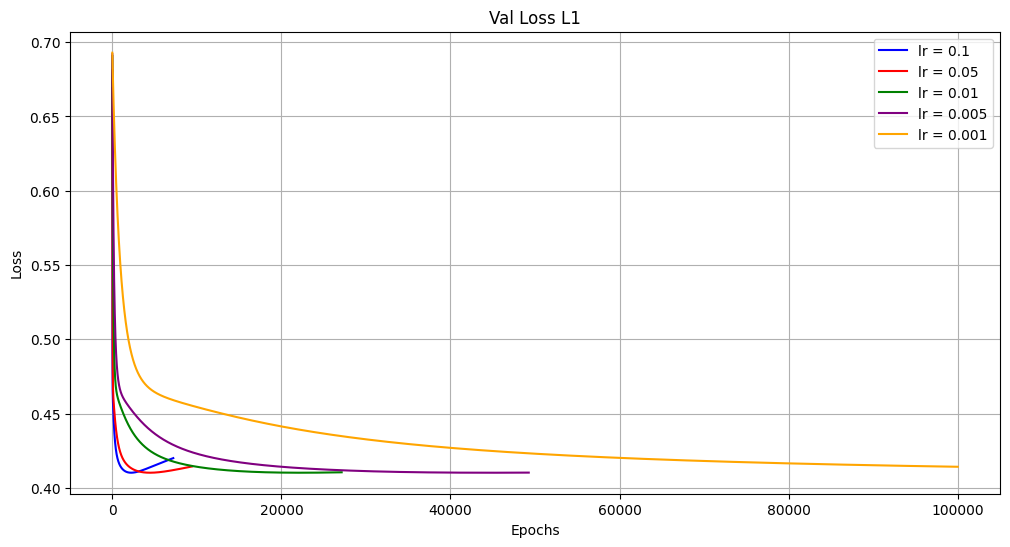

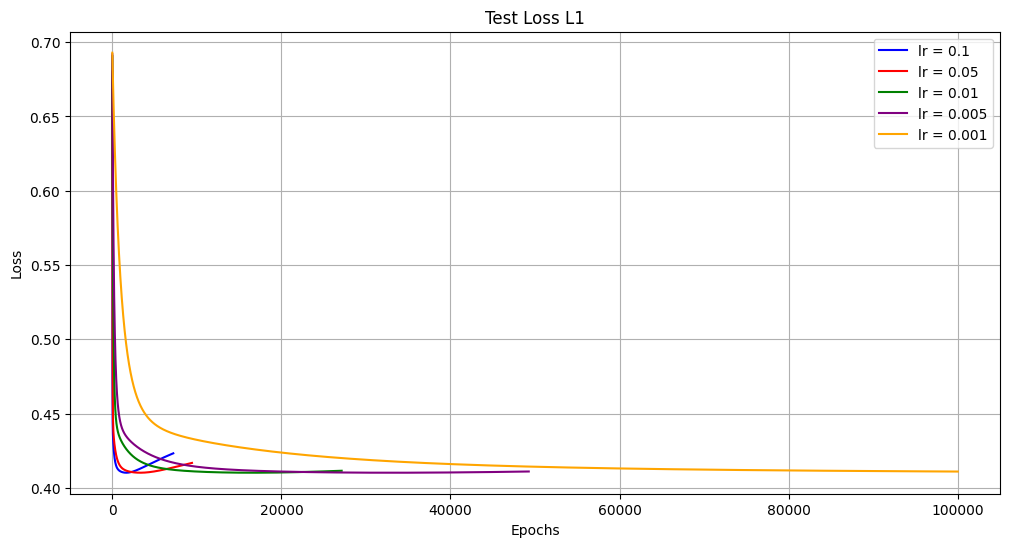

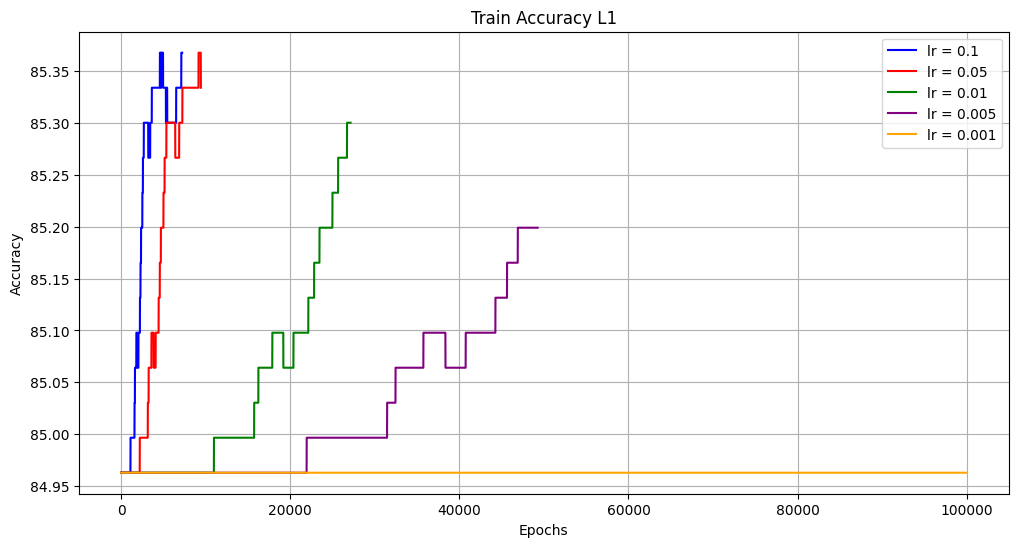

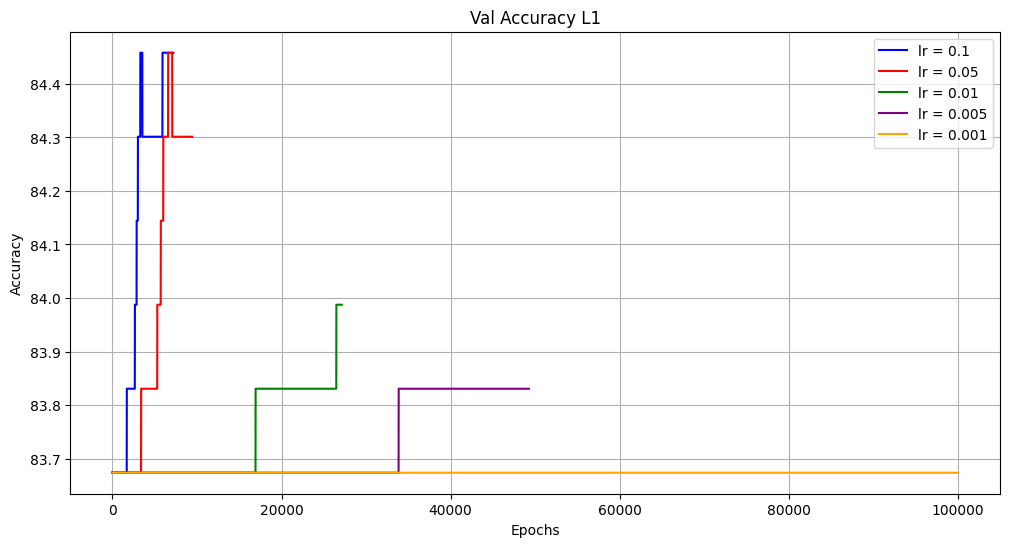

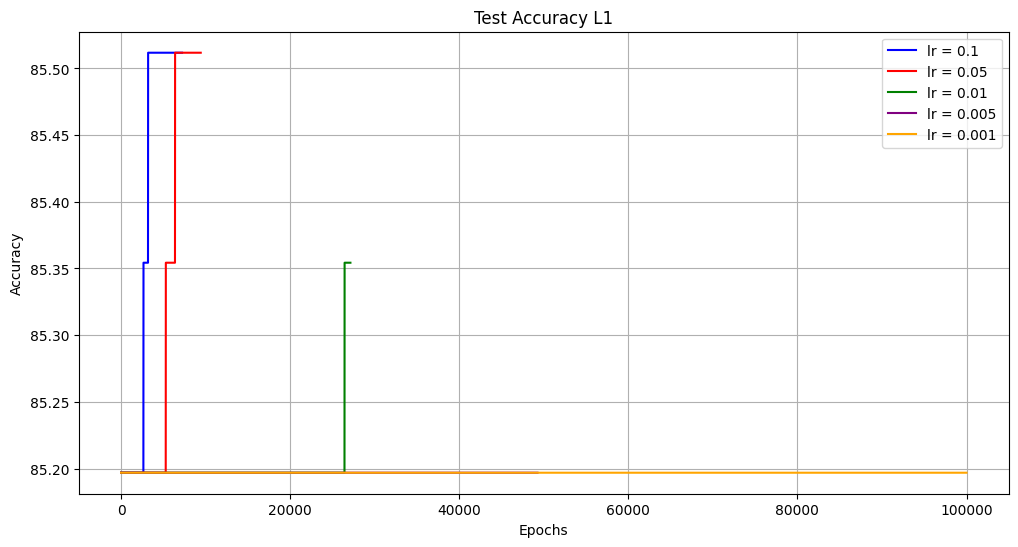

In [242]:
labels = ['lr = 0.1', 'lr = 0.05', 'lr = 0.01', 'lr = 0.005', 'lr = 0.001']
getPlot(train_loss_lists, labels, 'Train Loss L1', 'Epochs', 'Loss')
getPlot(val_loss_lists, labels, 'Val Loss L1', 'Epochs', 'Loss')
getPlot(test_loss_lists, labels, 'Test Loss L1', 'Epochs', 'Loss')
getPlot(train_accuracy_lists, labels, 'Train Accuracy L1', 'Epochs', 'Accuracy')
getPlot(val_accuracy_lists, labels, 'Val Accuracy L1', 'Epochs', 'Accuracy')
getPlot(test_accuracy_lists, labels, 'Test Accuracy L1', 'Epochs', 'Accuracy')

In [243]:
train_loss_lists = []
test_loss_lists = []
val_loss_lists = []
train_accuracy_lists = []
val_accuracy_lists = []
test_accuracy_lists = []

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
for lr in learning_rates:
    print(f"LEARNING RATE: {lr} -----------------------------------------")
    weights_es, cost_train_list_es, cost_val_list_es, cost_test_list_es, accuracy_train_list_es, accuracy_val_list_es, accuracy_test_list_es, _, _, epoch = gradient_descent(X_train, Y_train, X_val, Y_val, X_test, Y_test, lr, epochs=100000, batch_size=train_size, patience= 5000, reg= 'L2', lambda_= 2)
    train_loss_lists.append(cost_train_list_es)
    val_loss_lists.append(cost_val_list_es)
    test_loss_lists.append(cost_test_list_es)
    train_accuracy_lists.append(accuracy_train_list_es)
    val_accuracy_lists.append(accuracy_val_list_es)
    test_accuracy_lists.append(accuracy_test_list_es)

LEARNING RATE: 0.1 -----------------------------------------
Epoch 0: Train Loss: 0.6686, Train Accuracy: 84.96%
Epoch 10: Train Loss: 0.5316, Train Accuracy: 84.96%
Epoch 20: Train Loss: 0.4841, Train Accuracy: 84.96%
Epoch 30: Train Loss: 0.4644, Train Accuracy: 84.96%
Epoch 40: Train Loss: 0.4549, Train Accuracy: 84.96%
Epoch 50: Train Loss: 0.4496, Train Accuracy: 84.96%
Epoch 60: Train Loss: 0.4462, Train Accuracy: 84.96%
Epoch 70: Train Loss: 0.4437, Train Accuracy: 84.96%
Epoch 80: Train Loss: 0.4417, Train Accuracy: 84.96%
Epoch 90: Train Loss: 0.4400, Train Accuracy: 84.96%
Epoch 100: Train Loss: 0.4384, Train Accuracy: 84.96%
Epoch 110: Train Loss: 0.4369, Train Accuracy: 84.96%
Epoch 120: Train Loss: 0.4356, Train Accuracy: 84.96%
Epoch 130: Train Loss: 0.4343, Train Accuracy: 84.96%
Epoch 140: Train Loss: 0.4331, Train Accuracy: 84.96%
Epoch 150: Train Loss: 0.4319, Train Accuracy: 84.96%
Epoch 160: Train Loss: 0.4308, Train Accuracy: 84.96%
Epoch 170: Train Loss: 0.4297, T

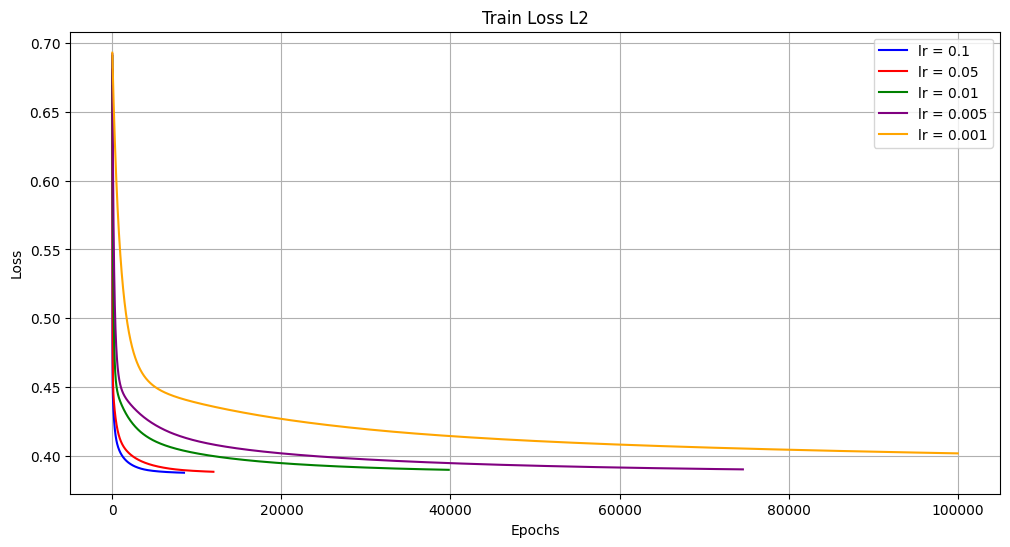

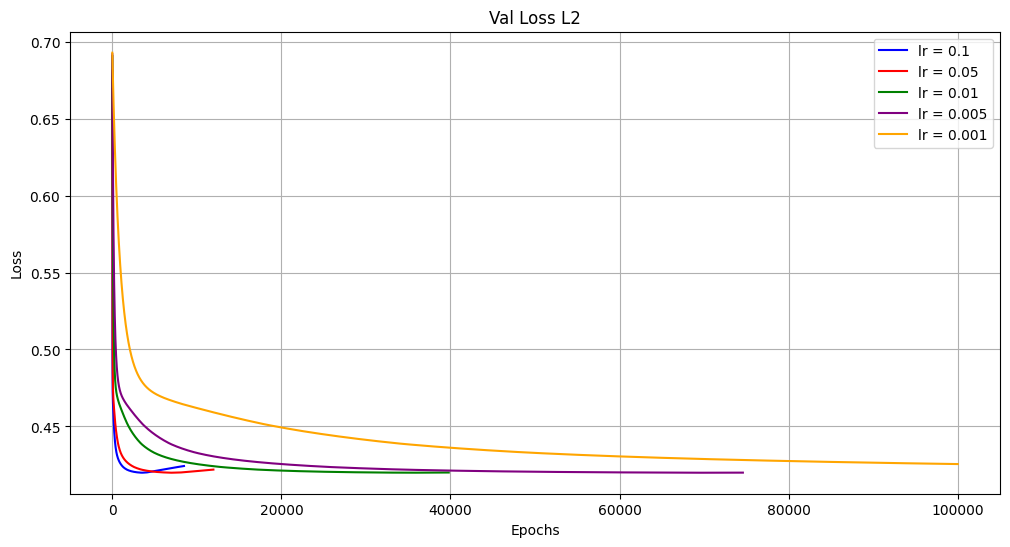

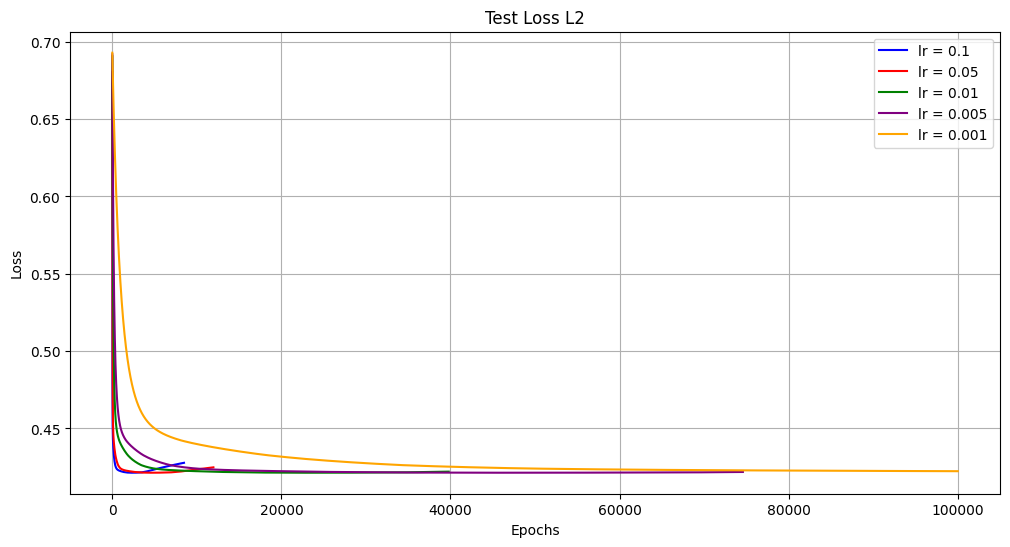

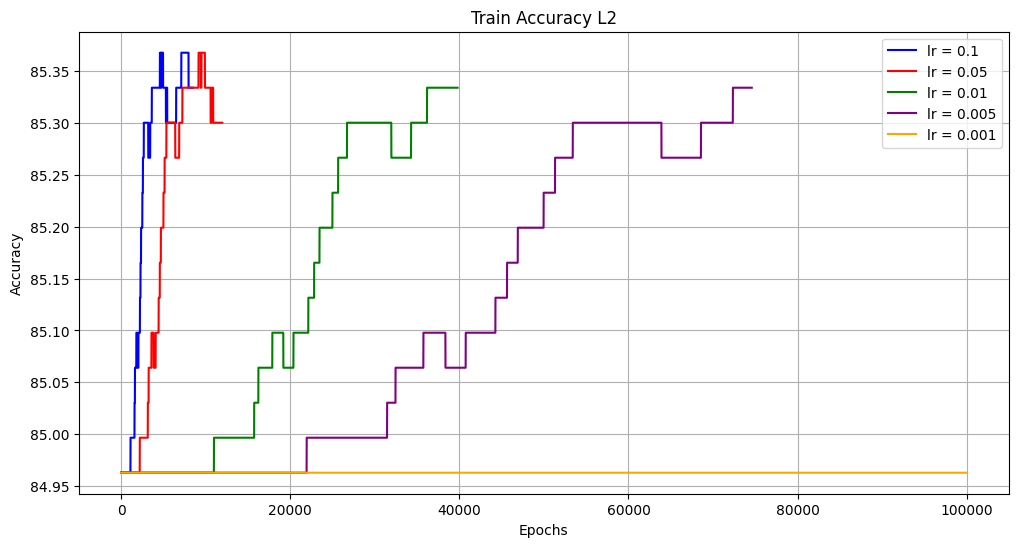

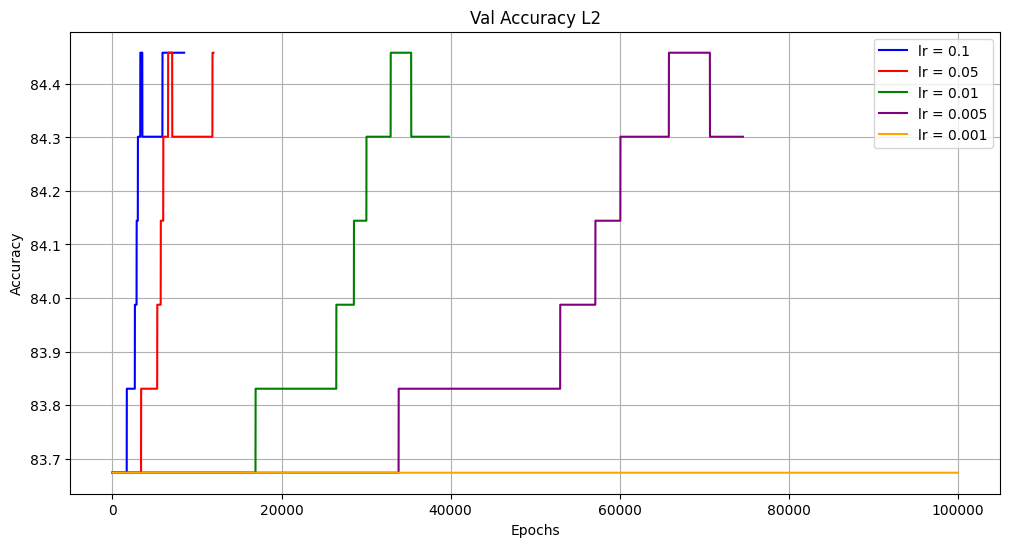

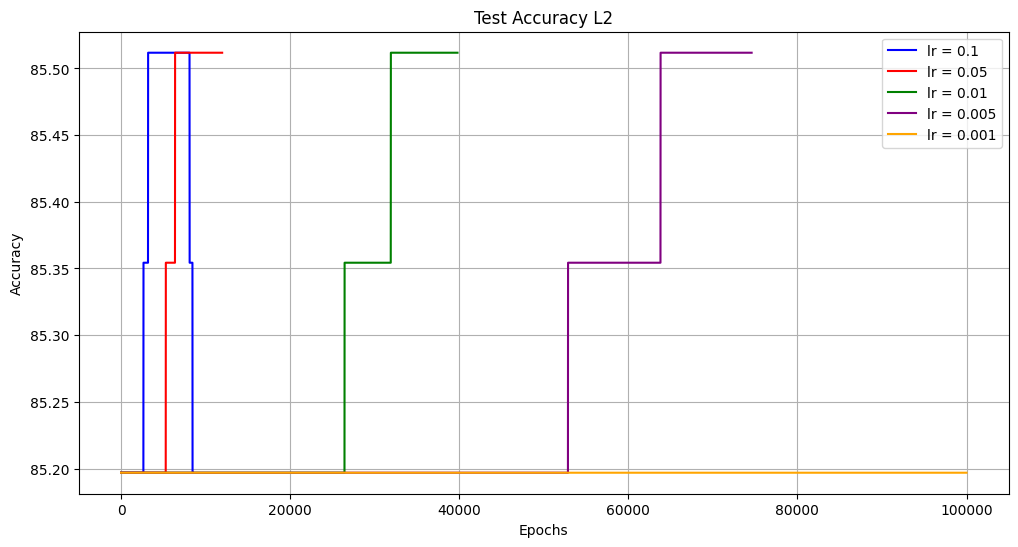

In [244]:
labels = ['lr = 0.1', 'lr = 0.05', 'lr = 0.01', 'lr = 0.005', 'lr = 0.001']
getPlot(train_loss_lists, labels, 'Train Loss L2', 'Epochs', 'Loss')
getPlot(val_loss_lists, labels, 'Val Loss L2', 'Epochs', 'Loss')
getPlot(test_loss_lists, labels, 'Test Loss L2', 'Epochs', 'Loss')
getPlot(train_accuracy_lists, labels, 'Train Accuracy L2', 'Epochs', 'Accuracy')
getPlot(val_accuracy_lists, labels, 'Val Accuracy L2', 'Epochs', 'Accuracy')
getPlot(test_accuracy_lists, labels, 'Test Accuracy L2', 'Epochs', 'Accuracy')